## Importing Modules

필요한 모듈을 Import 합니다.


In [50]:
# Modules About Hydra
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import DictConfig

# Modules About Torch, Numpy
import numpy as np
import torch
import torch.nn.functional as F
import torchmetrics
import torchvision
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import datasets, transforms

# Modules About Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

# Modules About Pandas, Matplotlib, Numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Others
from typing import List, Any
from PIL import Image


## Configure Dataset

Custom Dataset을 구성합니다.


In [52]:
from pytorch_lightning.utilities.types import EVAL_DATALOADERS


class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 64, data_dir: str = "./"):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.predicted_dataloader_attr = None

        # Define Transforms
        def repeat_channels(x):
            return x.repeat(3, 1, 1)

        self.transform = transforms.Compose([
            transforms.ToTensor()
            # ViT expects 224x224 images
            # transforms.Resize((224, 224), antialias=True),
            # transforms.Lambda(repeat_channels)  # ViT expects 3 channels
        ])

    def prepare_data(self):
        # Download MNIST Data
        datasets.MNIST(
            self.data_dir, train=True, download=True)
        datasets.MNIST(
            self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        mnist_train = datasets.MNIST(
            self.data_dir, train=True, transform=self.transform)
        mnist_test = datasets.MNIST(
            self.data_dir, train=False, transform=self.transform)

        # Split Dataset
        self.mnist_train, self.mnist_val = random_split(
            mnist_train, [55000, 5000])
        self.mnist_test = mnist_test

    # def _collate_fn(self, samples):
    #     이 함수를 사용할 경우
    #     DataLoader에 인자로 collate_fn=_collate_fn 를 추가해야합니다.
    #     pass

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

    def predict_dataloader(self):
        return self.predict_dataloader_attr

    def predict_instantly(self, x: List[Any], y: List[int]):
        to_tensor = torchvision.transforms.ToTensor()
        tensor_x = torch.stack([to_tensor(item) for item in x])
        tensor_y = torch.tensor(y)

        return tensor_x, tensor_y


## Design Model

Model 구조를 정의합니다.


In [24]:
class CNNModel(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.save_hyperparameters()
        self.config = config
        self.id2label = {i: i for i in range(10)}
        self.label2id = {i: i for i in range(10)}
        self.loss_func = nn.CrossEntropyLoss()
        self.model = nn.Sequential(
            # Convolutional layer 1
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolutional layer 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fully connected layers
            nn.Flatten(),

            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 10),  # assuming output has 10 classes
        )

    def forward(self, x, y):
        logits = self.model(x)
        loss = self.loss_func(logits, y)
        return loss, logits


## Task Model

Task 구조를 정의합니다.


In [84]:
class ClassificationTask(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        # self.save_hyperparameters()
        # self.config = config
        self.model = model

    def forward(self, x, y):
        loss, logits = self.model(x, y)
        return loss, logits

    def training_step(self, batch, batch_idx):
        loss, acc = self._shared_step(batch)
        metrics = {"train_acc": acc, "train_loss": loss}
        self.log_dict(metrics, prog_bar=True)
        return loss

    # def on_train_epoch_end(self):
    #     pass

    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_step(batch)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics, prog_bar=True)

    # def on_validation_epoch_end(self):
    #     pass

    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_step(batch)
        metrics = {"test_acc": acc, "test_loss": loss}
        self.log_dict(metrics, prog_bar=True)

    def _shared_step(self, batch):
        x, y = batch
        loss, logits = self.model(x, y)
        acc_fn = torchmetrics.classification.MulticlassAccuracy(
            num_classes=10).to(self.device)
        acc = acc_fn(logits, y)
        return loss, acc

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        loss, logits = self.model(x, y)
        return loss, logits

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=2e-5)

## Model Training

Model Training을 수행합니다.


In [26]:
# 데이터 로드 및 훈련
data_module = MNISTDataModule()
config = {}
models = [CNNModel(config=config)]
for model in models:
    task = ClassificationTask(model)
    trainer = pl.Trainer(max_epochs=1)
    trainer.fit(task, data_module)
    trainer.test(task, datamodule=data_module)
    trainer.save_checkpoint("test_checkpoints/best_model.ckpt")


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | CNNModel | 429 K 
-----------------------------------
429 K     Trainable params
0         Non-trainable params
429 K     Total params
1.717     Total estimated model params size (MB)


/opt/homebrew/Caskroom/miniconda/base/envs/jobVS_infra_test/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/jobVS_infra_test/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 860/860 [00:30<00:00, 28.52it/s, v_num=121, train_acc=0.750, train_loss=0.654, val_acc=0.823, val_loss=0.698]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 860/860 [00:30<00:00, 28.51it/s, v_num=121, train_acc=0.750, train_loss=0.654, val_acc=0.823, val_loss=0.698]


/opt/homebrew/Caskroom/miniconda/base/envs/jobVS_infra_test/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 157/157 [00:03<00:00, 43.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8261076211929321
        test_loss           0.6879092454910278
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Model Prediction

직접 Model Prediction을 수행하여 모델이 제대로 동작하는지 검증합니다.


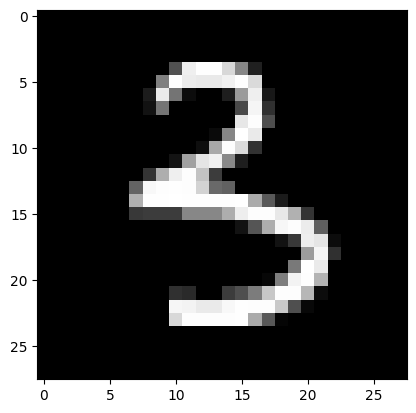

True label: 3, Predicted label: 3


In [85]:
data_module = MNISTDataModule()
# MNIST 테스트 데이터셋 로드
predict_dataset = datasets.MNIST(
    root='./', train=False, download=True)

# 랜덤 이미지 선택
random_idx = torch.randint(len(predict_dataset), size=(1,)).item()
image, true_label = predict_dataset[random_idx]

# 이미지 확인 (optional)
transform = torchvision.transforms.ToTensor()
image_tensor = transform(image)
plt.imshow(image_tensor[0].squeeze(), cmap='gray')
plt.show()


# 모델 생성 및 학습된 가중치 로드
model_config = {}
model = ClassificationTask.load_from_checkpoint(
    "test_checkpoints/best_model.ckpt", model=CNNModel(config=model_config))

model.eval()
with torch.no_grad():
    x, y = data_module.predict_instantly([image], [true_label])
    loss, logits = model(x, y)

# Predict Data를 원하는 DataLoader로 직접 만들어서 predict를 수행하고자 할 경우
# data_module.predicted_dataloader_attr = your_dataloader
# trainer = pl.Trainer()
# loss, logits = trainer.predict(model, datamodule=data_module)


# 가장 높은 확률을 가진 클래스 예측
_, predicted_class = torch.max(logits, dim=1)

print(f'True label: {true_label}, Predicted label: {predicted_class.item()}')